# **Metodología Mejorada para el Análisis Exploratorio y Discretización de Engagement**

## **4. Metodología**

### **4.1 Procesamiento de datos**

El procesamiento de datos garantiza que la variable *Engagement* y el resto del conjunto estén en condiciones óptimas para su análisis.

#### **a) Limpieza**

* **Valores faltantes:**

  * Identificación de registros incompletos.
  * Aplicación de imputación o eliminación según el porcentaje y relevancia.
* **Duplicados:**

  * Detección de registros repetidos por persona, fecha o combinaciones clave.
  * Conservación únicamente de entradas válidas.
* **Outliers:**

  * Uso de métodos como IQR, Z-score o visualizaciones (boxplots).
  * Decisión informada: corregir, transformar o excluir según el caso.

#### **b) Transformaciones**

* **Normalización o estandarización** (solo si se requieren comparaciones o métodos sensibles a escala).
* **Codificación de variables categóricas** para análisis comparativo por equipo, región, etc.
* **Transformaciones matemáticas** para revisar posibles relaciones funcionales:

  * Logaritmos
  * Potencias/polinomios
  * Escalados no lineales
* **Creación de variables derivadas**:

  * Engagement por día
  * Variación diaria o semanal
  * Tasa de crecimiento o decaimiento

---

### **4.2 Análisis Exploratorio de Datos (EDA)**

El EDA se centra en **entender la estructura, distribución y comportamiento temporal del Engagement**, para así fundamentar una discretización adecuada.

#### **a) Análisis de distribución**

* **Histogramas** para visualizar forma y dispersión.
* **KDE (Kernel Density Estimation)** para detectar modos (bimodalidad, sesgos).
* **Boxplots y violín plots** para identificar rangos típicos, asimetrías y outliers.

#### **b) Análisis estadístico descriptivo**

* Medidas clave:

  * Media, mediana, moda
  * Desviación estándar
  * Cuartiles (Q1, Q2, Q3)
  * Percentiles relevantes (P10, P25, P75, P90)
* Evaluación de:

  * Sesgo
  * Curtosis
  * Estabilidad temporal

Estas métricas ayudan a definir puntos de quiebre naturales para discretización.

#### **c) Análisis temporal**

* Series de tiempo por empleado, equipo y global.
* Gráficas de líneas para detectar tendencias, ciclos o cambios bruscos.
* Cálculo de estabilidad:

  * Varianza por persona
  * Diferencias día a día (ΔEngagement)

Esto permite definir discretizaciones adaptadas a la dinámica real del comportamiento.

#### **d) Análisis por segmentos**

* Comparación de Engagement según:

  * Equipo
  * Rol
  * Seniority
  * Proyecto
  * Región/horario
* Boxplots segmentados
* Distribuciones acumuladas para ver consistencia entre grupos.

Si los segmentos presentan distribuciones distintas, la discretización podría necesitar ser **dependiente del grupo**.

#### **e) Identificación de reglas naturales para discretizar**

A partir de los análisis previos, identificar:

* **Umbrales naturales** (quiebres claros en histogramas/KDE).
* **Rangos basados en cuartiles**:

  * Bajo (< Q1),
  * Medio (Q1–Q3),
  * Alto (> Q3)
* **Clusters** si existen grupos bien definidos:

  * Aplicación opcional de K-Means o Gaussian Mixture Models
  * Validación con métodos como silhouette score.

#### **f) Evaluación de múltiples esquemas de discretización**

Para asegurar robustez:

* Probar alternativas:

  * Cuartiles
  * Terciles
  * Quintiles
  * K-means
  * Natural breaks (Jenks)
* Comparar:

  * Balance entre categorías
  * Estabilidad temporal
  * Interpretabilidad
  * Relación con KPIs o métricas relevantes

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
from scipy import stats

In [44]:
data = pd.read_csv('data/data_globant.csv')  # Cargar los datos
data.head()

,Date,Email,Name,Position,Seniority,Location,Studio,Client,Client Tag,Project,Project Tag,Team Name,Engagement,Email Leader,Year,Month,Day
0,02Jan23,natalia.ramirez@tec.globant.com,Natalia Ramírez,Software Developer,Jr,CO/ANT/MED,Engineering,GreenWave Innovations,GWI001,Atlas Initiative,ATLINT,Breaking Badger,3.04,laura.leon@tec.globant.com,2023,1,2
1,03Jan23,natalia.ramirez@tec.globant.com,Natalia Ramírez,Software Developer,Jr,CO/ANT/MED,Engineering,GreenWave Innovations,GWI001,Atlas Initiative,ATLINT,Breaking Badger,2.99,laura.leon@tec.globant.com,2023,1,3
2,04Jan23,natalia.ramirez@tec.globant.com,Natalia Ramírez,Software Developer,Jr,CO/ANT/MED,Engineering,GreenWave Innovations,GWI001,Atlas Initiative,ATLINT,Breaking Badger,2.97,laura.leon@tec.globant.com,2023,1,4
3,05Jan23,natalia.ramirez@tec.globant.com,Natalia Ramírez,Software Developer,Jr,CO/ANT/MED,Engineering,GreenWave Innovations,GWI001,Atlas Initiative,ATLINT,Breaking Badger,2.75,laura.leon@tec.globant.com,2023,1,5
4,06Jan23,natalia.ramirez@tec.globant.com,Natalia Ramírez,Software Developer,Jr,CO/ANT/MED,Engineering,GreenWave Innovations,GWI001,Atlas Initiative,ATLINT,Breaking Badger,3.15,laura.leon@tec.globant.com,2023,1,6


In [45]:
# Limpieza de datos
print('Información del dataset:')
data.info()
print('\nValores faltantes por columna:')
print(data.isnull().sum())
print('\nNúmero de duplicados:', data.duplicated().sum())
if data.duplicated().sum() > 0:
    data = data.drop_duplicates()
    print('Duplicados eliminados.')
# Outliers en Engagement usando IQR
Q1 = data['Engagement'].quantile(0.25)
Q3 = data['Engagement'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data[(data['Engagement'] < lower_bound) | (data['Engagement'] > upper_bound)]
print(f'\nNúmero de outliers en Engagement: {len(outliers)}')
print(f'Rango típico: [{lower_bound:.2f}, {upper_bound:.2f}]')
# Convertir Date a datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d%b%y')

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11366 entries, 0 to 11365
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          11366 non-null  object 
 1   Email         11366 non-null  object 
 2   Name          11366 non-null  object 
 3   Position      11366 non-null  object 
 4   Seniority     11366 non-null  object 
 5   Location      11366 non-null  object 
 6   Studio        11366 non-null  object 
 7   Client        11366 non-null  object 
 8   Client Tag    11366 non-null  object 
 9   Project       11366 non-null  object 
 10  Project Tag   11366 non-null  object 
 11  Team Name     11366 non-null  object 
 12  Engagement    11366 non-null  float64
 13  Email Leader  10226 non-null  object 
 14  Year          11366 non-null  int64  
 15  Month         11366 non-null  int64  
 16  Day           11366 non-null  int64  
dtypes: float64(1), int64(3), object(13)
memory u

Estadísticas descriptivas de Engagement:
count    11366.000000
mean         2.995252
std          1.005442
min          0.000000
25%          2.520000
50%          3.050000
75%          3.600000
max          5.000000
Name: Engagement, dtype: float64

Percentiles:
0.10    2.00
0.25    2.52
0.50    3.05
0.75    3.60
0.90    4.14
Name: Engagement, dtype: float64

Sesgo: -0.82
Curtosis: 1.49


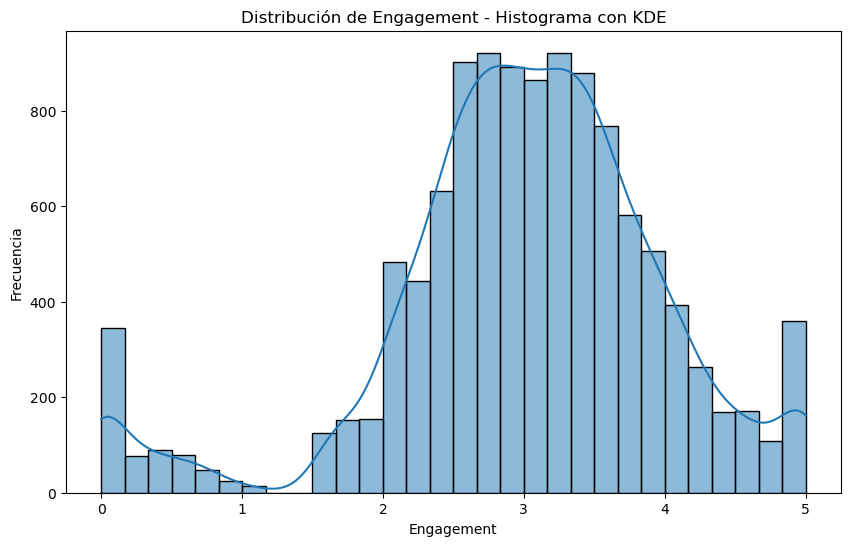

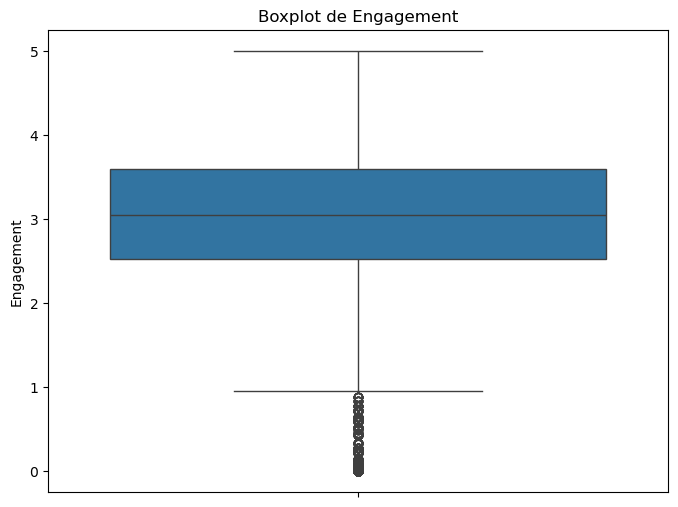

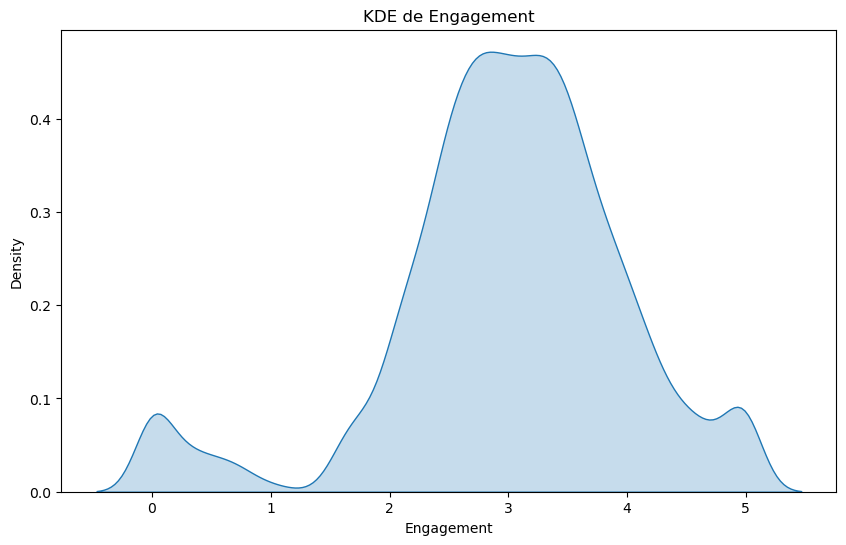

In [46]:
# Análisis Exploratorio de Datos - Distribución
print('Estadísticas descriptivas de Engagement:')
print(data['Engagement'].describe())
print('\nPercentiles:')
print(data['Engagement'].quantile([0.1, 0.25, 0.5, 0.75, 0.9]))
print(f'\nSesgo: {data["Engagement"].skew():.2f}')
print(f'Curtosis: {data["Engagement"].kurtosis():.2f}')
# Histograma con KDE
plt.figure(figsize=(10,6))
sns.histplot(data['Engagement'], kde=True, bins=30)
plt.title('Distribución de Engagement - Histograma con KDE')
plt.xlabel('Engagement')
plt.ylabel('Frecuencia')
plt.show()
# Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(y=data['Engagement'])
plt.title('Boxplot de Engagement')
plt.show()
# KDE separado
plt.figure(figsize=(10,6))
sns.kdeplot(data['Engagement'], fill=True)
plt.title('KDE de Engagement')
plt.xlabel('Engagement')
plt.show()

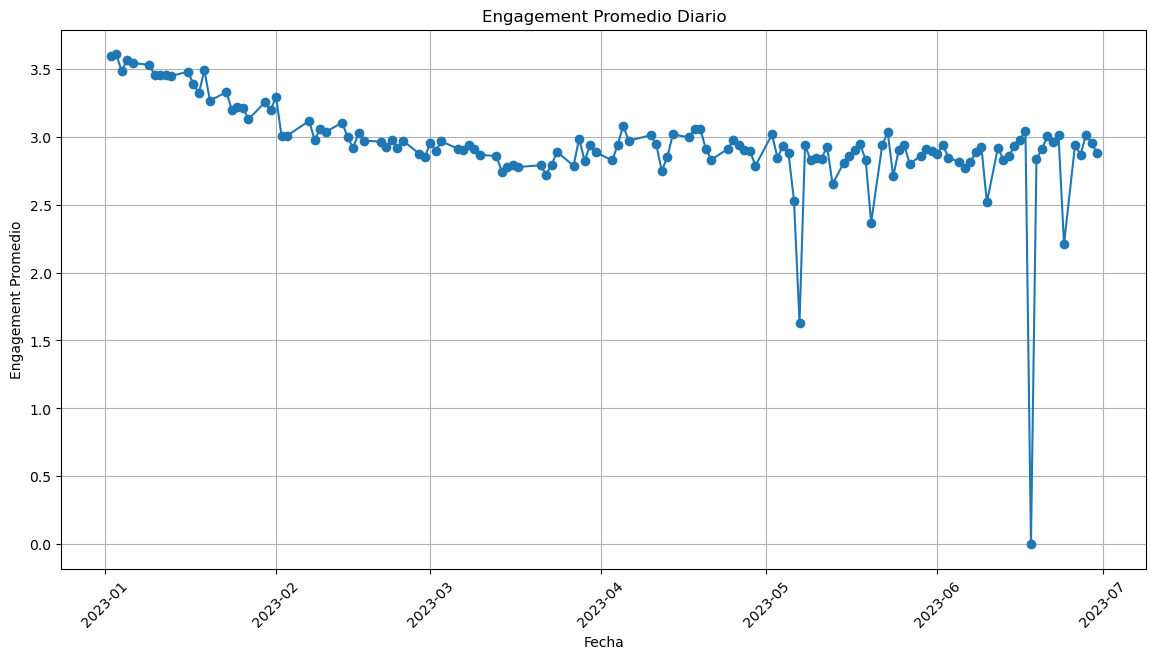

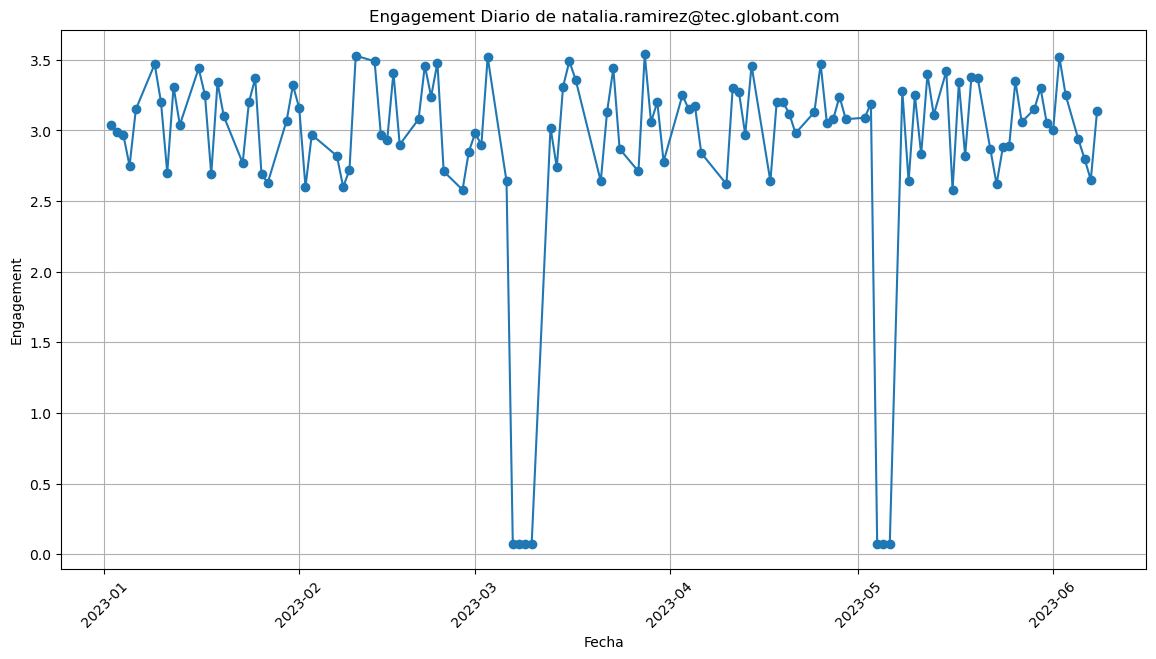

Varianza promedio de Engagement por persona: 0.7179593689594184

Estadísticas de diferencias día a día:
count    11272.000000
mean        -0.006412
std          0.866946
min         -4.900000
25%         -0.240000
50%          0.000000
75%          0.230000
max          4.900000
Name: Engagement_diff, dtype: float64


In [47]:
# Análisis Temporal
# Engagement promedio por día
daily_engagement = data.groupby('Date')['Engagement'].mean().reset_index()
plt.figure(figsize=(14,7))
plt.plot(daily_engagement['Date'], daily_engagement['Engagement'], marker='o')
plt.title('Engagement Promedio Diario')
plt.xlabel('Fecha')
plt.ylabel('Engagement Promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
# Serie de tiempo para un empleado de ejemplo
employee = data['Email'].unique()[0]
emp_data = data[data['Email'] == employee].sort_values('Date')
plt.figure(figsize=(14,7))
plt.plot(emp_data['Date'], emp_data['Engagement'], marker='o')
plt.title(f'Engagement Diario de {employee}')
plt.xlabel('Fecha')
plt.ylabel('Engagement')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
# Varianza por persona
variance_per_person = data.groupby('Email')['Engagement'].var()
print('Varianza promedio de Engagement por persona:', variance_per_person.mean())
# Diferencias día a día
data_sorted = data.sort_values(['Email', 'Date'])
data_sorted['Engagement_diff'] = data_sorted.groupby('Email')['Engagement'].diff()
print('\nEstadísticas de diferencias día a día:')
print(data_sorted['Engagement_diff'].dropna().describe())

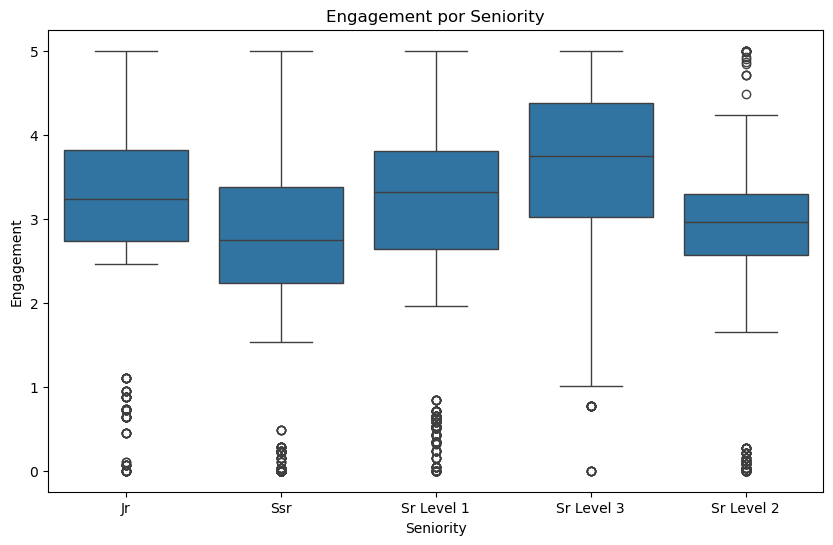

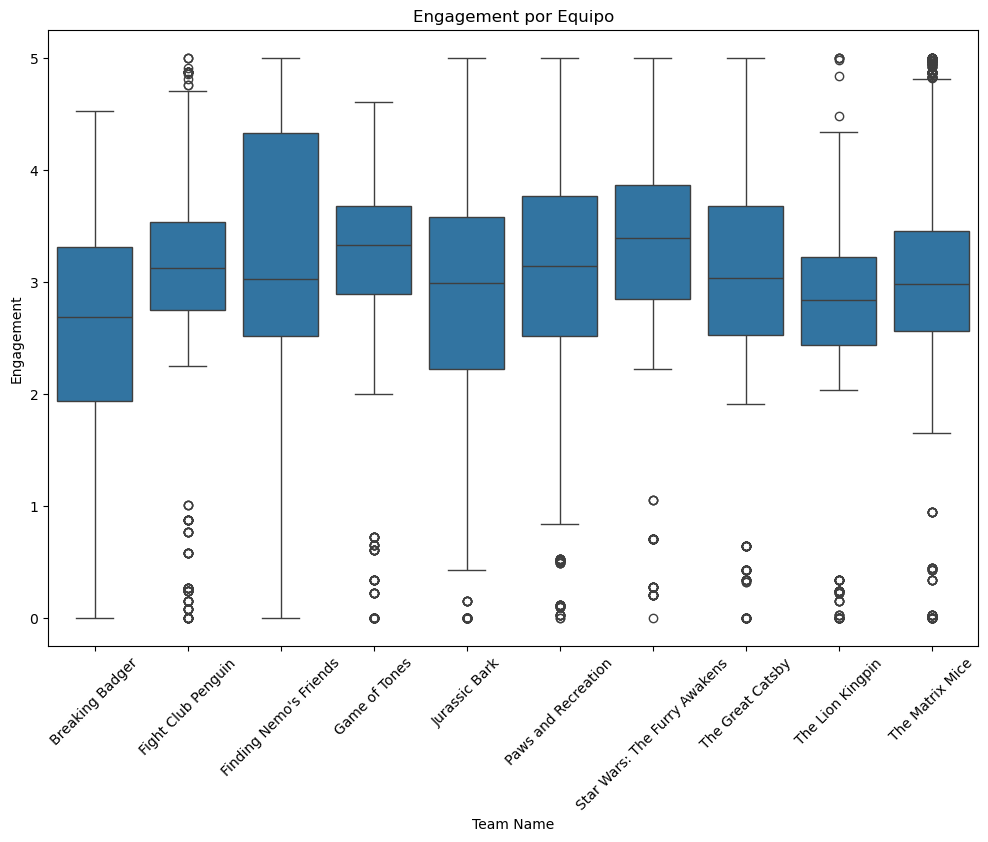

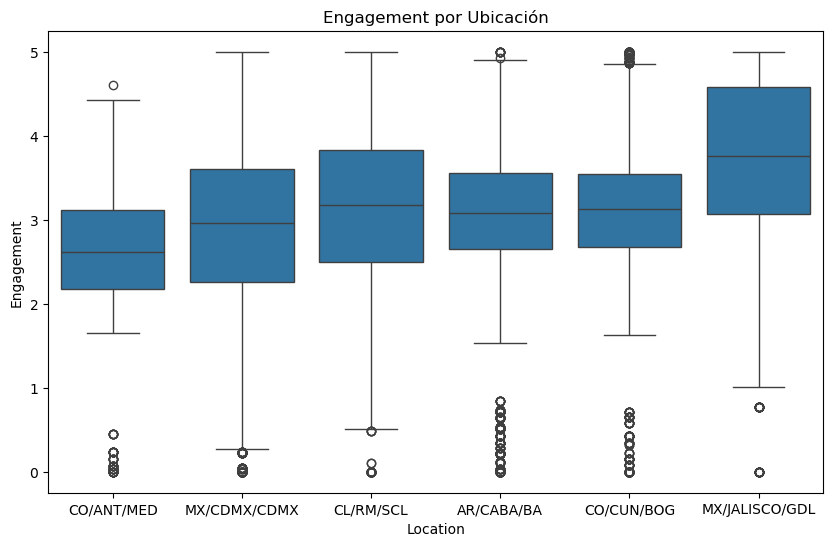

Media de Engagement por Seniority:
Seniority
Jr            3.239536
Sr Level 1    3.177163
Sr Level 2    2.825160
Sr Level 3    3.615582
Ssr           2.755869
Name: Engagement, dtype: float64

Media por Equipo:
Team Name
Breaking Badger                 2.620415
Fight Club Penguin              2.985719
Finding Nemo's Friends          3.231062
Game of Tones                   3.121522
Jurassic Bark                   2.889323
Paws and Recreation             3.099356
Star Wars: The Furry Awakens    3.356747
The Great Catsby                3.014105
The Lion Kingpin                2.754529
The Matrix Mice                 2.988195
Name: Engagement, dtype: float64

Media por Ubicación:
Location
AR/CABA/BA        3.003495
CL/RM/SCL         3.037897
CO/ANT/MED        2.639639
CO/CUN/BOG        3.056737
MX/CDMX/CDMX      2.869904
MX/JALISCO/GDL    3.691915
Name: Engagement, dtype: float64


In [48]:
# Análisis por Segmentos
# Engagement por Seniority
plt.figure(figsize=(10,6))
sns.boxplot(x='Seniority', y='Engagement', data=data)
plt.title('Engagement por Seniority')
plt.show()
# Engagement por Equipo
plt.figure(figsize=(12,8))
sns.boxplot(x='Team Name', y='Engagement', data=data)
plt.title('Engagement por Equipo')
plt.xticks(rotation=45)
plt.show()
# Engagement por Ubicación
plt.figure(figsize=(10,6))
sns.boxplot(x='Location', y='Engagement', data=data)
plt.title('Engagement por Ubicación')
plt.show()
# Estadísticas descriptivas por segmento
print('Media de Engagement por Seniority:')
print(data.groupby('Seniority')['Engagement'].mean())
print('\nMedia por Equipo:')
print(data.groupby('Team Name')['Engagement'].mean())
print('\nMedia por Ubicación:')
print(data.groupby('Location')['Engagement'].mean())

Cuartiles de Engagement:
0.25    2.52
0.50    3.05
0.75    3.60
Name: Engagement, dtype: float64

Distribución por categorías cuartiles:
Engagement_quartiles
Bajo          2934
Medio-Alto    2867
Alto          2807
Medio-Bajo    2758
Name: count, dtype: int64

Centros de clusters:
[2.41793651 4.31451058 0.26615611 3.30738954]

Distribución por clusters:
Engagement_clusters
3    4685
0    3969
1    2033
2     679
Name: count, dtype: int64


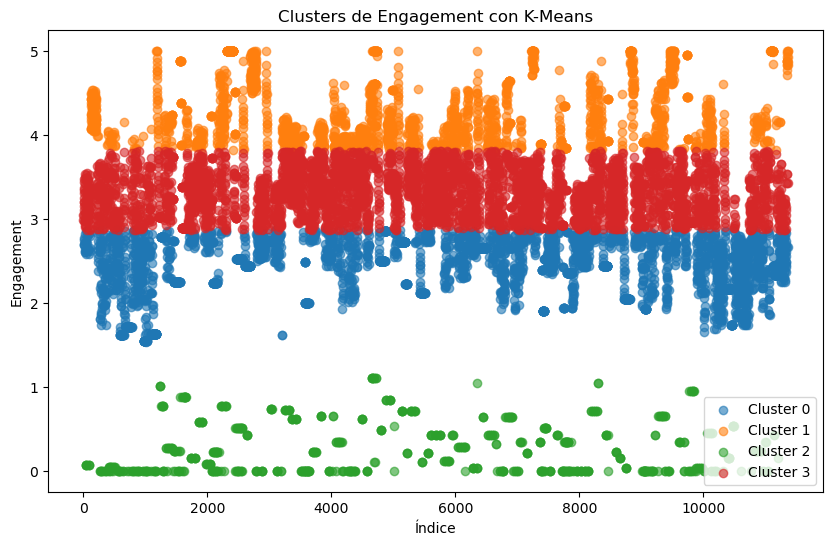

In [49]:
# Identificación de reglas naturales para discretización
# Cuartiles
quartiles = data['Engagement'].quantile([0.25, 0.5, 0.75])
print('Cuartiles de Engagement:')
print(quartiles)
# Categorías basadas en cuartiles
def categorize_quartiles(x):
    if x <= quartiles[0.25]:
        return 'Bajo'
    elif x <= quartiles[0.5]:
        return 'Medio-Bajo'
    elif x <= quartiles[0.75]:
        return 'Medio-Alto'
    else:
        return 'Alto'
data['Engagement_quartiles'] = data['Engagement'].apply(categorize_quartiles)
print('\nDistribución por categorías cuartiles:')
print(data['Engagement_quartiles'].value_counts())
# Clusters con K-Means
from sklearn.cluster import KMeans
engagement = data[['Engagement']]
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
data['Engagement_clusters'] = kmeans.fit_predict(engagement)
print('\nCentros de clusters:')
print(kmeans.cluster_centers_.flatten())
print('\nDistribución por clusters:')
print(data['Engagement_clusters'].value_counts())
# Visualizar clusters
plt.figure(figsize=(10,6))
colors = ['red', 'blue', 'green']
for cluster in sorted(data['Engagement_clusters'].unique()):
    subset = data[data['Engagement_clusters'] == cluster]
    plt.scatter(subset.index, subset['Engagement'], label=f'Cluster {cluster}', alpha=0.6)
plt.title('Clusters de Engagement con K-Means')
plt.xlabel('Índice')
plt.ylabel('Engagement')
plt.legend()
plt.show()

In [50]:
# Evaluación de múltiples esquemas de discretización
# Terciles
terciles = data['Engagement'].quantile([1/3, 2/3])
print('Terciles de Engagement:')
print(terciles)
def categorize_terciles(x):
    if x <= terciles[1/3]:
        return 'Bajo'
    elif x <= terciles[2/3]:
        return 'Medio'
    else:
        return 'Alto'
data['Engagement_terciles'] = data['Engagement'].apply(categorize_terciles)
print('\nDistribución terciles:')
print(data['Engagement_terciles'].value_counts())
# Quintiles
quintiles = data['Engagement'].quantile([0.2, 0.4, 0.6, 0.8])
print('\nQuintiles:')
print(quintiles)
# KBinsDiscretizer
kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
data['Engagement_kbins'] = kbins.fit_transform(engagement)
print('\nDistribución KBins (3 bins):')
print(data['Engagement_kbins'].value_counts())
# Comparar balance entre esquemas
schemes = ['Engagement_quartiles', 'Engagement_terciles', 'Engagement_clusters', 'Engagement_kbins']
for scheme in schemes:
    print(f'\nBalance para {scheme}:')
    print(data[scheme].value_counts())
# Estabilidad temporal: cuartiles por mes
data['Month'] = data['Date'].dt.month
monthly_quartiles = data.groupby('Month')['Engagement'].quantile([0.25, 0.5, 0.75])
print('\nCuartiles por mes:')
print(monthly_quartiles)

Terciles de Engagement:
0.333333    2.72
0.666667    3.41
Name: Engagement, dtype: float64

Distribución terciles:
Engagement_terciles
Bajo     3899
Alto     3752
Medio    3715
Name: count, dtype: int64

Quintiles:
0.2    2.41
0.4    2.85
0.6    3.27
0.8    3.74
Name: Engagement, dtype: float64

Distribución KBins (3 bins):
Engagement_kbins
2.0    3825
1.0    3774
0.0    3767
Name: count, dtype: int64

Balance para Engagement_quartiles:
Engagement_quartiles
Bajo          2934
Medio-Alto    2867
Alto          2807
Medio-Bajo    2758
Name: count, dtype: int64

Balance para Engagement_terciles:
Engagement_terciles
Bajo     3899
Alto     3752
Medio    3715
Name: count, dtype: int64

Balance para Engagement_clusters:
Engagement_clusters
3    4685
0    3969
1    2033
2     679
Name: count, dtype: int64

Balance para Engagement_kbins:
Engagement_kbins
2.0    3825
1.0    3774
0.0    3767
Name: count, dtype: int64

Cuartiles por mes:
Month      
1      0.25    2.9125
       0.50    3.4400
     

4. Metodología
    - Modelo(s):
        * Justificación de la elección del modelo o técnica.
        * Supuestos e hiperparámetros (si aplican).
        * Implementación del modelo.
        * Ajuste de hiperparámetros (si aplica): Random search, grid search, Bayesian optimization.
    - Evaluación:
        * Métricas utilizadas para evaluar el desempeño (precisión, recall, RMSE, etc.).
        * Métodos de validación (train-test split, cross-validation, etc.).
5. Resultados
    - Visualización de resultados:
        * Gráficos que expliquen el desempeño del modelo o el análisis realizado.
    - Interpretación:
        * Explicación clara de lo que significan los resultados.

6. Discusión
    - Implicaciones: Relevancia de los resultados en el contexto del problema.
    - Limitaciones: Factores que pudieron haber afectado el análisis o los resultados.
    - Posibles mejoras: Sugerencias para mejorar el análisis o los datos.

## Cuartiles
### Engagement y Team Name 

In [51]:
data["Team Name"].unique()

array(['Breaking Badger', 'Fight Club Penguin', "Finding Nemo's Friends",
       'Game of Tones', 'Jurassic Bark', 'Paws and Recreation',
       'Star Wars: The Furry Awakens', 'The Great Catsby',
       'The Lion Kingpin', 'The Matrix Mice'], dtype=object)

In [52]:
# Promedio por día para tener solo una observación diaria por Team Name
cuartiles_map = {'Bajo': 0, 'Medio-Bajo': 1, 'Medio-Alto': 2, 'Alto': 3}
data['Engagement_quartiles_num'] = data['Engagement_quartiles'].map(cuartiles_map)
ultimo_dia_global = data['Date'].max()

# Filtrar para excluir el último día
data_sin_ultimo_dia = data[data['Date'] < ultimo_dia_global]

# Agrupar normalmente
daily_data = (
    data_sin_ultimo_dia.groupby(['Team Name', 'Date'], as_index=False)
        .agg({'Engagement_quartiles_num': 'mean'})
)

# Redondear el promedio al cuartil más cercano
daily_data['Engagement_quartiles_num'] = daily_data['Engagement_quartiles_num'].round().astype(int)

# Ordenar por Team y fecha
daily_data = daily_data.sort_values(['Team Name', 'Date'])
daily_data.head()

,Team Name,Date,Engagement_quartiles_num
0,Breaking Badger,2023-01-02,2
1,Breaking Badger,2023-01-03,2
2,Breaking Badger,2023-01-04,2
3,Breaking Badger,2023-01-05,2
4,Breaking Badger,2023-01-06,2


In [53]:
def obtener_matriz_transicion_quartiles(team_name, daily_data):
    """
    Regresa la matriz de transición de Markov (4x4) para un equipo específico
    usando la variable Engagement_quartiles_num.
    """
    # 1. Filtrar datos del equipo
    df_team = daily_data[daily_data['Team Name'] == team_name]
    
    if df_team.empty:
        print(f"No se encontraron datos para el equipo '{team_name}'.")
        return None
    
    # 2. Obtener estados ordenados temporalmente
    states = df_team['Engagement_quartiles_num'].values
    
    # 3. Construir diccionario de transiciones
    transitions = {}
    for s1, s2 in zip(states[:-1], states[1:]):
        if s1 not in transitions:
            transitions[s1] = {}
        if s2 not in transitions[s1]:
            transitions[s1][s2] = 0
        transitions[s1][s2] += 1
    
    # 4. Crear matriz 4x4
    markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
    
    # 5. Normalizar a probabilidades
    for s1, dests in transitions.items():
        total = sum(dests.values())
        for s2, count in dests.items():
            markov_matrix.loc[s1, s2] = count / total
    
    return markov_matrix


In [54]:
matriz_badger = obtener_matriz_transicion_quartiles("Breaking Badger", daily_data)
print(matriz_badger)

          0         1         2  3
0  0.000000  0.750000  0.250000  0
1  0.026087  0.947826  0.026087  0
2  0.062500  0.250000  0.687500  0
3  0.000000  0.000000  0.000000  0


/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/165816071.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/165816071.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/165816071.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.25' has dtype in

In [55]:
matriz_nemo = obtener_matriz_transicion_quartiles("Finding Nemo's Friends", daily_data)
print(matriz_nemo)

   0         1         2         3
0  0  0.000000  0.000000  0.000000
1  0  0.800000  0.200000  0.000000
2  0  0.394737  0.526316  0.078947
3  0  0.000000  0.363636  0.636364


/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/165816071.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/165816071.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6363636363636364' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/165816071.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3636

### Engagement y ubicación

In [56]:
# Agrupar normalmente
daily_data_cuartiles_ubicacion = (
    data_sin_ultimo_dia.groupby(['Location', 'Date'], as_index=False)
        .agg({'Engagement_quartiles_num': 'mean'})
)

# Redondear el promedio al cuartil más cercano
daily_data_cuartiles_ubicacion['Engagement_quartiles_num'] = daily_data_cuartiles_ubicacion['Engagement_quartiles_num'].round().astype(int)

# Ordenar por Team y fecha
daily_data_cuartiles_ubicacion = daily_data_cuartiles_ubicacion.sort_values(['Location', 'Date'])
daily_data_cuartiles_ubicacion.head()


def obtener_matriz_transicion_quartiles_location(location, daily_data):
    """
    Regresa la matriz de transición de Markov (4x4) para un equipo específico
    usando la variable Engagement_quartiles_num.
    """
    # 1. Filtrar datos del equipo
    df_location = daily_data_cuartiles_ubicacion[daily_data_cuartiles_ubicacion['Location'] == location]
    
    if df_location.empty:
        print(f"No se encontraron datos para la ubicación '{location}'.")
        return None
    
    # 2. Obtener estados ordenados temporalmente
    states = df_location['Engagement_quartiles_num'].values
    
    # 3. Construir diccionario de transiciones
    transitions = {}
    for s1, s2 in zip(states[:-1], states[1:]):
        if s1 not in transitions:
            transitions[s1] = {}
        if s2 not in transitions[s1]:
            transitions[s1][s2] = 0
        transitions[s1][s2] += 1
    
    # 4. Crear matriz 4x4
    markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
    
    # 5. Normalizar a probabilidades
    for s1, dests in transitions.items():
        total = sum(dests.values())
        for s2, count in dests.items():
            markov_matrix.loc[s1, s2] = count / total
    
    return markov_matrix

matriz_gdl = obtener_matriz_transicion_quartiles_location("MX/JALISCO/GDL", daily_data_cuartiles_ubicacion)
print(matriz_gdl)

   0         1         2         3
0  0  0.000000  0.000000  0.000000
1  0  0.142857  0.857143  0.000000
2  0  0.069767  0.837209  0.093023
3  0  0.000000  0.258065  0.741935


/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/1892526488.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/1892526488.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7419354838709677' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/1892526488.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2

In [86]:
matriz_co = obtener_matriz_transicion_quartiles_location("CO/ANT/MED", daily_data_cuartiles_ubicacion)
print(matriz_co)

          0         1         2  3
0  0.333333  0.666667  0.000000  0
1  0.101010  0.818182  0.080808  0
2  0.000000  0.562500  0.437500  0
3  0.000000  0.000000  0.000000  0


/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/1892526488.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/1892526488.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/1892526488.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4375' has dty

## Terciles

In [57]:
# Cálculo de terciles para Engagement
terciles = data['Engagement'].quantile([0.33, 0.66])
print("Terciles:")
print(terciles)

Terciles:
0.33    2.71
0.66    3.40
Name: Engagement, dtype: float64


In [58]:
# Función para categorizar usando terciles
def categorize_terciles(x):
    if x <= terciles[0.33]:
        return 'Bajo'
    elif x <= terciles[0.66]:
        return 'Medio'
    else:
        return 'Alto'

data['Engagement_terciles'] = data['Engagement'].apply(categorize_terciles)
data[['Engagement', 'Engagement_terciles']].head()

,Engagement,Engagement_terciles
0,3.04,Medio
1,2.99,Medio
2,2.97,Medio
3,2.75,Medio
4,3.15,Medio


In [59]:
# Mapeo de categorías a valores numéricos
terciles_map = {'Bajo': 0, 'Medio': 1, 'Alto': 2}

data['Engagement_terciles_num'] = data['Engagement_terciles'].map(terciles_map)
data[['Engagement_terciles', 'Engagement_terciles_num']].head()

,Engagement_terciles,Engagement_terciles_num
0,Medio,1
1,Medio,1
2,Medio,1
3,Medio,1
4,Medio,1


In [60]:
# Promedio por día para tener solo una observación diaria por Team Name
terciles_map = {'Bajo': 0, 'Medio': 1, 'Alto': 2}
data['Engagement_terciles_num'] = data['Engagement_terciles'].map(terciles_map)
ultimo_dia_global_terciles = data['Date'].max()
data_sin_ultimo_dia = data[data['Date'] < ultimo_dia_global_terciles]

# Agrupar por Team y Fecha → obtener el promedio diario
daily_data_terciles = (
    data_sin_ultimo_dia.groupby(['Team Name', 'Date'], as_index=False)
        .agg({'Engagement_terciles_num': 'mean'})
)


# Redondear el promedio al tercil más cercano
daily_data_terciles['Engagement_terciles_num'] = daily_data_terciles['Engagement_terciles_num'].round().astype(int)

# Ordenar por Team y fecha
daily_data_terciles= daily_data_terciles.sort_values(['Team Name', 'Date'])
daily_data_terciles.head()

,Team Name,Date,Engagement_terciles_num
0,Breaking Badger,2023-01-02,1
1,Breaking Badger,2023-01-03,1
2,Breaking Badger,2023-01-04,1
3,Breaking Badger,2023-01-05,1
4,Breaking Badger,2023-01-06,1


In [61]:
def obtener_matriz_transicion_terciles(team_name, daily_data_terciles):
    """
    Regresa la matriz de transición de Markov (3x3) para un equipo específico.
    """
    # 1. Filtrar datos del equipo
    df_team = daily_data_terciles[daily_data_terciles['Team Name'] == team_name]
    
    # Validación
    if df_team.empty:
        print(f"No se encontraron datos para el equipo '{team_name}'.")
        return None

    # 2. Obtener estados en orden temporal
    states = df_team['Engagement_terciles_num'].values
    
    # 3. Construir transiciones del equipo
    transitions = {}
    for s1, s2 in zip(states[:-1], states[1:]):
        if s1 not in transitions:
            transitions[s1] = {}
        if s2 not in transitions[s1]:
            transitions[s1][s2] = 0
        transitions[s1][s2] += 1

    # 4. Crear matriz 3x3 vacía
    markov_matrix = pd.DataFrame(index=range(3), columns=range(3)).fillna(0)
    
    # 5. Normalizar
    for s1, dests in transitions.items():
        total = sum(dests.values())
        for s2, count in dests.items():
            markov_matrix.loc[s1, s2] = count / total

    return markov_matrix


In [62]:
matriz_badger = obtener_matriz_transicion_terciles("Breaking Badger", daily_data_terciles)
print(matriz_badger)

          0         1  2
0  0.515152  0.484848  0
1  0.156863  0.843137  0
2  0.000000  0.000000  0


/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/3265204261.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(3), columns=range(3)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/3265204261.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8431372549019608' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/3265204261.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1

In [63]:
matriz_nemo = obtener_matriz_transicion_terciles("Finding Nemo's Friends", daily_data_terciles)
print(matriz_nemo)

          0         1         2
0  0.333333  0.666667  0.000000
1  0.020619  0.948454  0.030928
2  0.000000  0.166667  0.833333


/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/3265204261.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(3), columns=range(3)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/3265204261.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8333333333333334' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/3265204261.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1

### Engagement y Ubicación

In [80]:
# Agrupar normalmente
daily_data_terciles_ubicacion = (
    data_sin_ultimo_dia.groupby(['Location', 'Date'], as_index=False)
        .agg({'Engagement_terciles_num': 'mean'})
)

# Redondear el promedio al cuartil más cercano
daily_data_terciles_ubicacion['Engagement_terciles_num'] = daily_data_terciles_ubicacion['Engagement_terciles_num'].round().astype(int)

# Ordenar por Team y fecha
daily_data_terciles_ubicacion = daily_data_terciles_ubicacion.sort_values(['Location', 'Date'])
daily_data_terciles_ubicacion.head()


def obtener_matriz_transicion_terciles_location(location, daily_data_terciles_ubicacion):
    """
    Regresa la matriz de transición de Markov (4x4) para un equipo específico
    usando la variable Engagement_terciles_num.
    """
    # 1. Filtrar datos del equipo
    df_location = daily_data_terciles_ubicacion[daily_data_terciles_ubicacion['Location'] == location]
    
    if df_location.empty:
        print(f"No se encontraron datos para la ubicación '{location}'.")
        return None
    
    # 2. Obtener estados ordenados temporalmente
    states = df_location['Engagement_terciles_num'].values
    
    # 3. Construir diccionario de transiciones
    transitions = {}
    for s1, s2 in zip(states[:-1], states[1:]):
        if s1 not in transitions:
            transitions[s1] = {}
        if s2 not in transitions[s1]:
            transitions[s1][s2] = 0
        transitions[s1][s2] += 1
    
    # 4. Crear matriz 4x4
    markov_matrix = pd.DataFrame(index=range(3), columns=range(3)).fillna(0)
    
    # 5. Normalizar a probabilidades
    for s1, dests in transitions.items():
        total = sum(dests.values())
        for s2, count in dests.items():
            markov_matrix.loc[s1, s2] = count / total
    
    return markov_matrix

matriz_gdl = obtener_matriz_transicion_terciles_location("MX/JALISCO/GDL", daily_data_terciles_ubicacion)
print(matriz_gdl)

   0         1         2
0  0  0.000000  0.000000
1  0  0.500000  0.500000
2  0  0.256098  0.743902


/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/3774403804.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(3), columns=range(3)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/3774403804.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7439024390243902' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/3774403804.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2

In [85]:
matriz_co = obtener_matriz_transicion_terciles_location("CO/ANT/MED", daily_data_terciles_ubicacion)
print(matriz_co)

          0         1  2
0  0.791045  0.208955  0
1  0.238095  0.761905  0
2  0.000000  0.000000  0


/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/3774403804.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(3), columns=range(3)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/3774403804.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7619047619047619' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/3774403804.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2

## Clústers

In [65]:
from sklearn.cluster import KMeans


# Usamos 4 clusters para poder comparar directamente con los Cuartiles
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(data[['Engagement']])

# Ordenar los clusters para que tengan sentido (0=Bajo, ..., 2=Alto)
sorted_idx = np.argsort(kmeans.cluster_centers_.flatten())
map_labels = {original: new for new, original in enumerate(sorted_idx)}

In [66]:
# Predecimos sobre todo el dataset y aplicamos el ordenamiento
data['cluster_temp'] = kmeans.predict(data[['Engagement']])
data['Engagement_clusters_num'] = data['cluster_temp'].map(map_labels)
ultimo_dia_global = data['Date'].max()
data_sin_ultimo = data[data['Date'] < ultimo_dia_global].copy()



### Engagement y Ubicación

In [67]:
# 1) Agrupar por Team Name + Date
daily_data_clusters_team = (
    data_sin_ultimo.groupby(['Team Name', 'Date'], as_index=False)[['Engagement']].mean()
)
daily_data_clusters_team['Engagement_clusters_num'] = kmeans.predict(daily_data_clusters_team[['Engagement']].values).astype(int)
daily_data_clusters_team['Engagement_clusters_num'] = daily_data_clusters_team['Engagement_clusters_num'].map(map_labels)
daily_data_clusters_team = daily_data_clusters_team.sort_values(['Team Name', 'Date'])

# Agrupar por Location + Date
daily_data_clusters_location = (
    data_sin_ultimo.groupby(['Location', 'Date'], as_index=False)[['Engagement']].mean()
)
daily_data_clusters_location['Engagement_clusters_num'] = kmeans.predict(daily_data_clusters_location[['Engagement']].values).astype(int)
daily_data_clusters_location['Engagement_clusters_num'] = daily_data_clusters_location['Engagement_clusters_num'].map(map_labels)
daily_data_clusters_location = daily_data_clusters_location.sort_values(['Location', 'Date'])

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [68]:
def obtener_matriz_transicion_clusters(team_name, daily_data_clusters_team):
    """
    Regresa la matriz de transición de Markov (4x4) para un equipo específico
    usando la variable Engagement_clusters_num (formato idéntico a cuartiles).
    """
    df_team = daily_data_clusters_team[daily_data_clusters_team['Team Name'] == team_name]
    if df_team.empty:
        # No hay datos para el equipo
        return None
    states = df_team['Engagement_clusters_num'].values
    if len(states) < 2:
        return None
    # Construir transiciones
    transitions = {}
    for s1, s2 in zip(states[:-1], states[1:]):
        transitions.setdefault(int(s1), {})
        transitions[int(s1)][int(s2)] = transitions[int(s1)].get(int(s2), 0) + 1
    # Crear matriz 4x4
    markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
    for s1, dests in transitions.items():
        total = sum(dests.values())
        for s2, count in dests.items():
            markov_matrix.loc[s1, s2] = count / total
    return markov_matrix

def obtener_matriz_transicion_clusters_location(location, daily_data_clusters_location):
    """
    Regresa la matriz de transición de Markov (4x4) para una ubicación específica
    usando la variable Engagement_clusters_num (formato idéntico a cuartiles).
    """
    df_loc = daily_data_clusters_location[daily_data_clusters_location['Location'] == location]
    if df_loc.empty:
        return None
    states = df_loc['Engagement_clusters_num'].values
    if len(states) < 2:
        return None
    transitions = {}
    for s1, s2 in zip(states[:-1], states[1:]):
        transitions.setdefault(int(s1), {})
        transitions[int(s1)][int(s2)] = transitions[int(s1)].get(int(s2), 0) + 1
    markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
    for s1, dests in transitions.items():
        total = sum(dests.values())
        for s2, count in dests.items():
            markov_matrix.loc[s1, s2] = count / total
    return markov_matrix



In [81]:
obtener_matriz_transicion_clusters("Breaking Badger", daily_data_clusters_team)

/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/2340696724.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/2340696724.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/2340696724.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.36' has dtype in

,0,1,2,3
0,0.00,0.000000,1.000000,0
1,0.00,0.926606,0.073394,0
2,0.04,0.360000,0.600000,0
3,0.00,0.000000,0.000000,0


In [82]:
obtener_matriz_transicion_clusters("Finding Nemo's Friends", daily_data_clusters_team)

/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/2340696724.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/2340696724.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6470588235294118' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/2340696724.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3

,0,1,2,3
0,0,0.000000,0.000000,0.000000
1,0,0.409091,0.590909,0.000000
2,0,0.152941,0.788235,0.058824
3,0,0.000000,0.352941,0.647059


In [83]:
obtener_matriz_transicion_clusters_location("MX/JALISCO/GDL", daily_data_clusters_location)

/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/2340696724.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/2340696724.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6909090909090909' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/2340696724.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2

,0,1,2,3
0,0,0.000000,0.000000,0.000000
1,0,0.200000,0.500000,0.300000
2,0,0.118644,0.644068,0.237288
3,0,0.018182,0.290909,0.690909


In [84]:
obtener_matriz_transicion_clusters_location("CO/ANT/MED", daily_data_clusters_location)

/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/2340696724.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/2340696724.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6363636363636364' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/2340696724.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3

,0,1,2,3
0,0.000000,1.000000,0.000000,0
1,0.010417,0.875000,0.114583,0
2,0.000000,0.363636,0.636364,0
3,0.000000,0.000000,0.000000,0


# 1. Construcción del modelo de Markov

Para cada esquema de discretización (cuartiles, terciles o clusters), el *Engagement* se transformó en una secuencia discreta de estados:

$$
S = (s_1, s_2, \ldots, s_T), \qquad s_t \in \{0,1,\ldots,K-1\}
$$

donde:

- $K = 4$ para cuartiles,  
- $K = 3$ para terciles,  
- $K = 4$ para clusters.

A partir de esa secuencia se estimó la matriz de transición de la cadena de Markov:

$$
P = [p_{ij}] \in \mathbb{R}^{K \times K}
$$

donde cada elemento $p_{ij}$ representa la probabilidad de pasar del estado $i$ al estado $j$.

## Estimación de la matriz de transición

La probabilidad se calculó a partir de frecuencias relativas:

$$
p_{ij} = \frac{N(i \rightarrow j)}{\sum_{j'=0}^{K-1} N(i \rightarrow j')}
$$

donde:

- $N(i \rightarrow j)$ = número de transiciones observadas de $i$ a $j$.

Esto produce una matriz donde cada renglón suma 1.

---

# 2. Cálculo de la log-verosimilitud

Dada la secuencia observada de estados:

$$
(s_1, s_2, \ldots, s_T)
$$

la verosimilitud del modelo de Markov es:

$$
L = \prod_{t=1}^{T-1} p_{s_t\, s_{t+1}}
$$

Para evitar problemas numéricos, se calcula la **log-verosimilitud**:

$$
\log L = \sum_{t=1}^{T-1} \log(p_{s_t\, s_{t+1}})
$$

Si alguna probabilidad es cero (transición nunca observada), se utiliza la corrección:

$$
\log(p_{ij}) \approx \log(\epsilon), \qquad \epsilon = 10^{-10}
$$

para evitar evaluar $\log(0)$.

---

# 3. Evaluación de los esquemas de discretización

Cada esquema produce una secuencia distinta de estados y, por lo tanto, matrices de transición distintas.  
Para evaluar cuál discretización describe mejor la dinámica de los datos, se calcula la log-verosimilitud total del modelo para cada equipo y cada esquema.

Formalmente, para un equipo $g$:

$$\log L_{\text{esquema}}(g)
=
\sum_{t=1}^{T_g-1}
\log\left(
p_{s_t\, s_{t+1}}^{(\text{esquema})}
\right)
$$

Luego se suman las log-verosimilitudes de todos los equipos:

$$
\log L_{\text{total, esquema}}
=
\sum_{g=1}^{G}
\log L_{\text{esquema}}(g)
$$

El esquema con mayor log-verosimilitud total es aquel que:

- explica mejor las transiciones observadas,
- penaliza menos las transiciones raras,
- y ajusta mejor la estructura real de la serie temporal.


# Log-Verosimilitud Total por Esquema de Discretización: Team Name

In [69]:
def log_verosimilitud_markov(states, transition_matrix):
    """
    Calcula la log-verosimilitud de una secuencia de estados dada una matriz de transición.
    
    states: lista/array de estados (ej. [0,1,1,2,3])
    transition_matrix: matriz de transición en un DataFrame o array
    """
    P = np.array(transition_matrix).astype(float)
    
    logL = 0
    for s1, s2 in zip(states[:-1], states[1:]):
        p = P[s1, s2]
        # evitar problemas con ceros
        if p == 0:
            logL += -1e9   # penalización grande
        else:
            logL += np.log(p)
    return logL


In [70]:
def evaluar_esquema_markov(daily_data, columna_estado, obtener_matriz_func):
    """
    Calcula la log-verosimilitud total del esquema de discretización para todos los equipos.
    
    daily_data: dataframe diario (cuartiles o terciles)
    columna_estado: nombre de la columna numérica del estado (ej. 'Engagement_quartiles_num')
    obtener_matriz_func: función para crear matriz (ya la tienes)
    """
    equipos = daily_data['Team Name'].unique()
    total_logL = 0
    resultados = {}

    for team in equipos:
        df_team = daily_data[daily_data['Team Name'] == team].sort_values('Date')
        states = df_team[columna_estado].values
        
        if len(states) < 2:
            continue

        # Construir matriz del equipo
        matriz = obtener_matriz_func(team, daily_data)
        if matriz is None:
            continue
        
        # Log-verosimilitud del equipo
        logL_team = log_verosimilitud_markov(states, matriz)
        resultados[team] = logL_team
        total_logL += logL_team
    
    return total_logL, resultados


In [71]:
LL_total_cuartiles, LL_por_equipo_cuartiles = evaluar_esquema_markov(
    daily_data=daily_data,
    columna_estado='Engagement_quartiles_num',
    obtener_matriz_func=obtener_matriz_transicion_quartiles
)
print("Log-Verosimilitud Total - Cuartiles con Team Name:", LL_total_cuartiles)

Log-Verosimilitud Total - Cuartiles con Team Name: -605.0437239094176


/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/165816071.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/165816071.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/165816071.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.25' has dtype in

In [72]:
LL_total_terciles, LL_por_equipo_terciles = evaluar_esquema_markov(
    daily_data=daily_data_terciles,
    columna_estado='Engagement_terciles_num',
    obtener_matriz_func=obtener_matriz_transicion_terciles
)
print("Log-Verosimilitud Total - Terciles con Team Name:", LL_total_terciles)

Log-Verosimilitud Total - Terciles con Team Name: -418.9529099649443


/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/3265204261.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(3), columns=range(3)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/3265204261.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8431372549019608' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/3265204261.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1

In [73]:
print("Comparación con Team Name:")
print(f"Cuartiles LL = {LL_total_cuartiles}")
print(f"Terciles LL  = {LL_total_terciles}")
print(f"Clusters LL  = {LL_total_clusters}")


# Aun no agrego clusters a este if, solo el print
if LL_total_cuartiles > LL_total_terciles:
    print("\n→ Cuartiles es mejor según log-verosimilitud.")
else:
    print("\n→ Terciles es mejor según log-verosimilitud.")

Comparación con Team Name:
Cuartiles LL = -605.0437239094176
Terciles LL  = -418.9529099649443
Clusters LL  = -656.7251680569947

→ Terciles es mejor según log-verosimilitud.


# Log-Verosimilitud Total por Esquema de Discretización: Location

In [74]:
def evaluar_esquema_markov_location(daily_data, columna_estado, obtener_matriz_func):
    """
    Calcula la log-verosimilitud total del esquema de discretización para todos los equipos.
    
    daily_data: dataframe diario (cuartiles o terciles)
    columna_estado: nombre de la columna numérica del estado (ej. 'Engagement_quartiles_num')
    obtener_matriz_func: función para crear matriz (ya la tienes)
    """
    ubicacion = daily_data['Location'].unique()
    total_logL = 0
    resultados = {}

    for ubicacion in ubicacion:
        df_location = daily_data[daily_data['Location'] == ubicacion].sort_values('Date')
        states = df_location[columna_estado].values
        
        if len(states) < 2:
            continue

        # Construir matriz del equipo
        matriz = obtener_matriz_func(ubicacion, daily_data)
        if matriz is None:
            continue
        
        # Log-verosimilitud del equipo
        logL_ubicacion = log_verosimilitud_markov(states, matriz)
        resultados[ubicacion] = logL_ubicacion
        total_logL += logL_ubicacion
    
    return total_logL, resultados


In [75]:
LL_total_cuartiles_ubicacion, LL_por_ubicacion_cuartiles = evaluar_esquema_markov_location(
    daily_data=daily_data_cuartiles_ubicacion,
    columna_estado='Engagement_quartiles_num',
    obtener_matriz_func=obtener_matriz_transicion_quartiles_location
)
print("Log-Verosimilitud Total - Cuartiles con Location:", LL_total_cuartiles_ubicacion)

Log-Verosimilitud Total - Cuartiles con Location: -479.6448466335544


/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/1892526488.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/1892526488.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7352941176470589' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/1892526488.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2

In [76]:
LL_total_terciles_location, LL_por_ubicacion_terciles = evaluar_esquema_markov_location(
    daily_data=daily_data_terciles_ubicacion,
    columna_estado='Engagement_terciles_num',
    obtener_matriz_func=obtener_matriz_transicion_terciles_location
)
print("Log-Verosimilitud Total - Terciles con Location:", LL_total_terciles_location)

Log-Verosimilitud Total - Terciles con Location: -268.13413806244733


/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/1635491136.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/1635491136.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9448818897637795' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/1635491136.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0

In [78]:
# Evaluación: Log-verosimilitud para clusters (Team Name)
LL_total_clusters, LL_por_equipo_clusters = evaluar_esquema_markov(
    daily_data=daily_data_clusters_team,
    columna_estado='Engagement_clusters_num',
    obtener_matriz_func=obtener_matriz_transicion_clusters
)
print("Log-Verosimilitud Total - Clusters con Team Name:", LL_total_clusters)

# Evaluación: Log-verosimilitud para clusters (Location)
LL_total_clusters_ubicacion, LL_por_ubicacion_clusters = evaluar_esquema_markov_location(
    daily_data=daily_data_clusters_location,
    columna_estado='Engagement_clusters_num',
    obtener_matriz_func=obtener_matriz_transicion_clusters_location
)
print("Log-Verosimilitud Total - Clusters con Location:", LL_total_clusters_ubicacion)

Log-Verosimilitud Total - Clusters con Team Name: -656.7251680569947
Log-Verosimilitud Total - Clusters con Location: -465.77937469798724


/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/2340696724.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  markov_matrix = pd.DataFrame(index=range(4), columns=range(4)).fillna(0)
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/2340696724.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  markov_matrix.loc[s1, s2] = count / total
/var/folders/9w/1hmhsxn974l_vhcstn1k4czm0000gn/T/ipykernel_75989/2340696724.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.36' has dtype in

In [79]:
print("Comparación con Engagement:")
print(f"Cuartiles LL = {LL_total_cuartiles_ubicacion}")
print(f"Terciles LL  = {LL_total_terciles_location}")
print(f"Clusters LL  = {LL_total_clusters_ubicacion}")

# tampoco he agregado clusters a este if, solo el print
if LL_total_cuartiles_ubicacion > LL_total_terciles_location:
    print("\n→ Cuartiles es mejor según log-verosimilitud.")
else:
    print("\n→ Terciles es mejor según log-verosimilitud.")

Comparación con Engagement:
Cuartiles LL = -479.6448466335544
Terciles LL  = -268.13413806244733
Clusters LL  = -465.77937469798724

→ Terciles es mejor según log-verosimilitud.


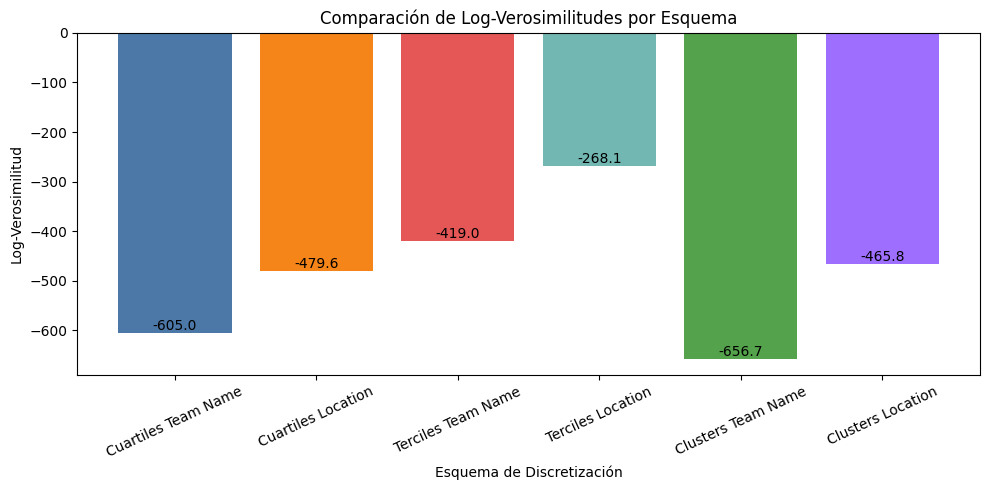

In [ ]:
# Valores de log-verosimilitud obtenidos
logL_cuartiles = LL_total_cuartiles
logL_cuartiles_ubicacion = LL_total_cuartiles_ubicacion
logL_terciles = LL_total_terciles
logL_terciles_ubicacion = LL_total_terciles_location
logL_clusters = LL_total_clusters
logL_clusters_ubicacion = LL_total_clusters_ubicacion

# Vector de valores y etiquetas (mismo orden entre ambos)
logL_values = [
    logL_cuartiles,
    logL_cuartiles_ubicacion,
    logL_terciles,
    logL_terciles_ubicacion,
    logL_clusters,
    logL_clusters_ubicacion
]
labels = ["Cuartiles Team Name", "Cuartiles Location", "Terciles Team Name", "Terciles Location", "Clusters Team Name", "Clusters Location"]

# Gráfica
plt.figure(figsize=(10,5))
bars = plt.bar(labels, logL_values, color=['#4C78A8', '#F58518', '#E45756', '#72B7B2', '#54A24B', '#9E6FFE'])
plt.title("Comparación de Log-Verosimilitudes por Esquema")
plt.ylabel("Log-Verosimilitud")
plt.xlabel("Esquema de Discretización")
plt.xticks(rotation=25)

# Mostrar valores encima de cada barra
for i, v in enumerate(logL_values):
    plt.text(i, v, f"{v:.1f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()
